<a href="https://colab.research.google.com/github/tsido/lda-thesis/blob/main/topic_extraction/lda/LDA_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for evaluation of LDA topic model

Creates a LDA topic model with 46 distinct topics with Octis.

Use Octis for optimizing the hyperparameters. Hyperparameters that are
explored are alpha and eta and we optimize for coherence.

Gensim LDA model is persisted to disk for further evaluation.

The evaluation and further investigation of the LDA model is also done in this Notebook.


In [1]:
# Fetch the app store data
!mkdir data
!wget --no-check-certificate --output-document=data/enriched_data.csv 'https://raw.githubusercontent.com/tsido/lda-thesis/main/data/enriched_data.csv'
!wget --no-check-certificate --output-document=data/optimization_results.csv 'https://raw.githubusercontent.com/tsido/lda-thesis/main/topic_extraction/lda/optimization_results.csv'

!mkdir data/octis


--2023-12-28 12:16:25--  https://raw.githubusercontent.com/tsido/lda-thesis/main/data/enriched_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31862266 (30M) [text/plain]
Saving to: ‘data/enriched_data.csv’

data/enriched_data. 100%[===================>]  30.39M   166MB/s    in 0.2s    

2023-12-28 12:16:25 (166 MB/s) - ‘data/enriched_data.csv’ saved [31862266/31862266]

--2023-12-28 12:16:26--  https://raw.githubusercontent.com/tsido/lda-thesis/main/topic_extraction/lda/optimization_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respo

In [2]:
!pip install octis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.3 MB/s eta 0:00:00
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp310-cp310-linux_x86_64.whl size=251406 sha256=d646c1a9b52180791b0dc82fc6df2761c2623db199a7e53e2b2fe8538da15eae
  Stored in directory: 

In [3]:
import inspect
import pickle

import pandas as pd
import numpy as np

from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

from gensim.corpora.dictionary import Dictionary



In [4]:
# Configuration options

# Run or skip optimization step, skip if the optimization data is already available
RUN_OPTIMIZER=False


num_topics = 46 # Number of topics to generate
top_k = 5      # Top words to inspect in metrics


In [5]:

# read in the document data
df = pd.read_csv('data/enriched_data.csv')

descriptions = df['PreprocessedDescription'].str.split()


In [6]:
# Prepare custom dataset in a format described
# here: https://github.com/MIND-Lab/OCTIS/tree/master/preprocessed_datasets/sample_dataset


df['PreprocessedDescription'].to_csv('data/octis/corpus.tsv', header=False, index=False)
#df['Description'].to_csv('data/octis/corpus.tsv', header=False, index=False)

# Create the vocabulary.txt file using Gensim and keep 2000 most relevant words only
dictionary = Dictionary(descriptions)

# remove tokens that don't occur in at least 3 documents
# and occur in over 50% of docs
dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=2000)

# create vocabulary.txt file by getting unique words from the dictionary
with open("data/octis/vocabulary.txt", "w") as f:
    for (k,word) in dictionary.items():
      f.write(word +'\n')


In [7]:
# Load the dataset
octis_dataset = Dataset()
octis_dataset.load_custom_dataset_from_folder('data/octis');


In [8]:
# Perform gridsearch using sklearn over the different
# combinations os Gensis parameters
# We can't use the OCTIS optimizer since it doesn't provide
# grid search over the categorical paramters we want (or at
# least I don't know how to use it for that)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

static_hyperparameters = {
    'num_topics': num_topics,
    'passes': 5, # 5
    'chunksize': 2000,
    'iterations': 50,  # 500
    'random_state': 0
    }

if (RUN_OPTIMIZER):

  search_grid = {

      'alpha': ['asymmetric', 'auto', 'symmetric'],
      'eta': ['auto', 'symmetric', 0.5, 1]
  }

  npmi = Coherence(topk=top_k, texts=octis_dataset.get_corpus(), measure='c_npmi')
  diversity = TopicDiversity(topk=top_k)

  param_search_df = pd.DataFrame(columns = ['alpha', 'eta', 'npmi', 'diversity'])

  for params in ParameterGrid(search_grid):
      model = LDA()

      model.hyperparameters.update(static_hyperparameters)
      model.set_hyperparameters(**params)

      model_output = model.train_model(octis_dataset, top_words=top_k)

      coherence_score = npmi.score(model_output)
      diversity_score = diversity.score(model_output)

      param_search_df.loc[len(param_search_df)] = {
          'alpha': model.hyperparameters['alpha'],
          'eta': model.hyperparameters['eta'],
          'npmi': coherence_score,
          'diversity': diversity_score
      };
      print(param_search_df)

  param_search_df.to_csv('data/optimization_results.csv')
else:
  print('Skipping optimizer. Use already found hyperparameters')


Skipping optimizer. Use already found hyperparameters


In [9]:
optimization_df = pd.read_csv('data/optimization_results.csv')
optimization_df

,Unnamed: 0,alpha,eta,npmi,diversity
0,0,auto,symmetric,0.055034,0.904348
1,1,auto,auto,0.055034,0.904348
2,2,asymmetric,symmetric,0.029717,0.882609
3,3,asymmetric,auto,0.029717,0.882609
4,4,symmetric,symmetric,0.055638,0.878261
5,5,symmetric,auto,0.055638,0.878261


In [10]:

# Create the final LDA model using alpha and eta parameters
# with highest coherence
static_hyperparameters['alpha'] = 'symmetric'
static_hyperparameters['eta'] = 1.0

model = LDA()
model.hyperparameters.update(static_hyperparameters)
model_output = model.train_model(octis_dataset)


In [11]:
diversity = TopicDiversity(topk=top_k) # Initialize metric
print("Diversity: ", diversity.score(model_output))


Diversity:  0.8913043478260869


In [12]:
descs = df['PreprocessedDescription']
texts = [doc.split(' ') for doc in descs]

coherence = Coherence(topk=top_k, texts=texts)
print("Coherence: ", coherence.score(model_output))

Coherence:  0.281510621284151


In [13]:
# print topics
gensim_lda = model.trained_model;
gensim_lda.print_topics(num_topics=num_topics, num_words=top_k)


[(0,
  '0.000*"chizuru" + 0.000*"shinsengumi" + 0.000*"hakuoki" + 0.000*"maroon" + 0.000*"onerepublic"'),
 (1,
  '0.001*"gioco" + 0.001*"briscola" + 0.000*"giocatori" + 0.000*"più" + 0.000*"giocare"'),
 (2, '0.001*"oyun" + 0.001*"bir" + 0.001*"ile" + 0.001*"okey" + 0.001*"puan"'),
 (3,
  '0.000*"машины" + 0.000*"signaling" + 0.000*"или" + 0.000*"при" + 0.000*"приложение"'),
 (4,
  '0.000*"goats" + 0.000*"gruff" + 0.000*"kaja" + 0.000*"dyrlie" + 0.000*"hench"'),
 (5,
  '0.000*"gumma" + 0.000*"prefecture" + 0.000*"gunma" + 0.000*"gacha" + 0.000*"kumamon"'),
 (6,
  '0.000*"「lotoくじ富豪買い」は任意の金額・番号を設定して、宝くじの当せんをシミュレーションするアプリです。" + 0.000*"あとは通常のlotoくじと同じ、運が良ければ儲かります！儲かる人は一握り！その一握りに選ばれるように祈りましょう！" + 0.000*"lotoは〜までの数字の中から異なるつの数字、lotoは〜までの数字の中から異なるつの数字、minilotoは〜までの数字の中から異なるつの数字を選びます。" + 0.000*"loto、loto、minilotoに対応しています。" + 0.000*"億の予算を決めます。ここで無制限を選ぶと好きなだけ結果を見ることができます。ぼんやりしたいときにオススメです。"'),
 (7,
  '0.000*"się" + 0.000*"jest" + 0.000*"minimini" + 0.000*"dla" + 0.000*"gra"'),
 (8,
  '0.018*"solita

In [14]:
#store the topic model to disk
!mkdir data/gensim
gensim_lda.save('data/gensim/gensim_lda.model')


In [17]:
topic_strings = []
topic_probabilities = []
n_top_topics = 3

corpus = [dictionary.doc2bow(desc) for desc in descriptions]


# turn the topics into actual words
for doc in corpus:
    doc_topic_strings = []
    doc_topic_probabilities = []

    doc_topics = gensim_lda.get_document_topics(doc)
    # sort topics by prob and get the top 3 topics for each doc
    doc_topics.sort(key=lambda x: x[1], reverse=True)

    for i in range(n_top_topics):
        topic_id = doc_topics[i][0] if i < len(doc_topics) else -1

        if topic_id == -1:
            doc_topic_strings.append(' ')
            doc_topic_probabilities.append(0)
            continue

        words = [w[0] for w in gensim_lda.show_topic(topic_id, topn=5)]
        doc_topic_strings.append(' '.join(words))
        doc_topic_probabilities.append(doc_topics[i][1])

    topic_strings.append(doc_topic_strings)
    topic_probabilities.append(doc_topic_probabilities)


In [18]:
# get top 3 scoring topics and create a data frame that contains the topics and the original document text
topic_df = pd.concat([df['App_Name'], df['PreprocessedDescription'], pd.DataFrame(topic_strings), pd.DataFrame(topic_probabilities)], axis=1)
topic_df.columns = ['AppName', 'TrimmedDescription', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_1_p', 'Topic_2_p', 'Topic_3_p']


In [19]:
topic_df

,AppName,TrimmedDescription,Topic_1,Topic_2,Topic_3,Topic_1_p,Topic_2_p,Topic_3_p
0,AAA³ Little Ponies & Unicorns,welcome land fairies puzzle game toddlers kids...,game play app games fun,game new play games free,,0.496857,0.366312,0.000000
1,GA1: An Assassin in Orlandes,interactive fantasy adventure book game rpg ga...,game new play games free,battle enemies weapons space fight,game play app games fun,0.479419,0.278271,0.234428
2,Baby Games App (by HAPPYTOUCH®),plenty press touch explore children ages happy...,game play app games fun,battle enemies weapons space fight,game new play games free,0.550433,0.239245,0.195850
3,Hadean Lands,winner xyzzy interactive fiction awards best p...,game play app games fun,game new play games free,,0.806759,0.179725,0.000000
4,Pango and friends,discover unpublished pango stories interactive...,game play app games fun,game new play games free,battle enemies weapons space fight,0.656473,0.263628,0.068823
...,...,...,...,...,...,...,...,...
12896,Touchdown Hero: New Season,new season finally field outmanoeuvre defender...,game play app games fun,game new play games free,,0.585994,0.368218,0.000000
12897,Hidden Objects USA Time Object,vacation usa explore beautiful travel spots me...,game play app games fun,game new play games free,battle enemies weapons space fight,0.486784,0.448822,0.055890
12898,Slots! Golden Cherry,number casino slot machine real play free fore...,game new play games free,game play app games fun,solitaire spider golf klondike freecell,0.638058,0.280338,0.064751
12899,XAirports,xairports utility app allows owner popular fli...,game new play games free,game play app games fun,,0.715187,0.273668,0.000000


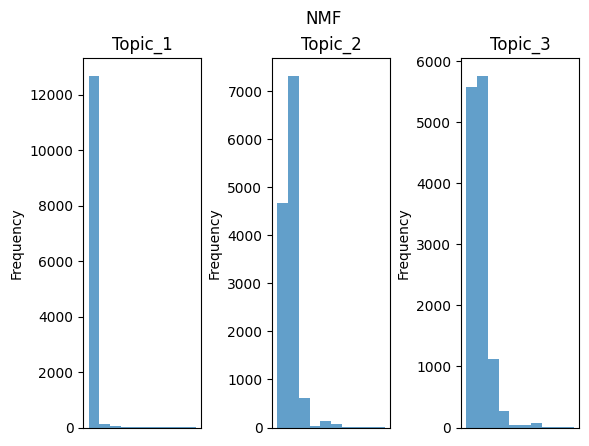

In [42]:
import matplotlib.pyplot as plt

# The topic distribution of this model is highly skewed

columns = ['Topic_1', 'Topic_2','Topic_3']

fig, ax = plt.subplots(nrows=1, ncols=3)
for i, column in enumerate(columns):
    ax[i].hist(topic_df[column], alpha=0.7)
    ax[i].set_title(column)
    ax[i].set_ylabel('Frequency')
    ax[i].get_xaxis().set_visible(False)

plt.subplots_adjust(wspace=0.6)
plt.suptitle('LDA topic distributions')
plt.show()

